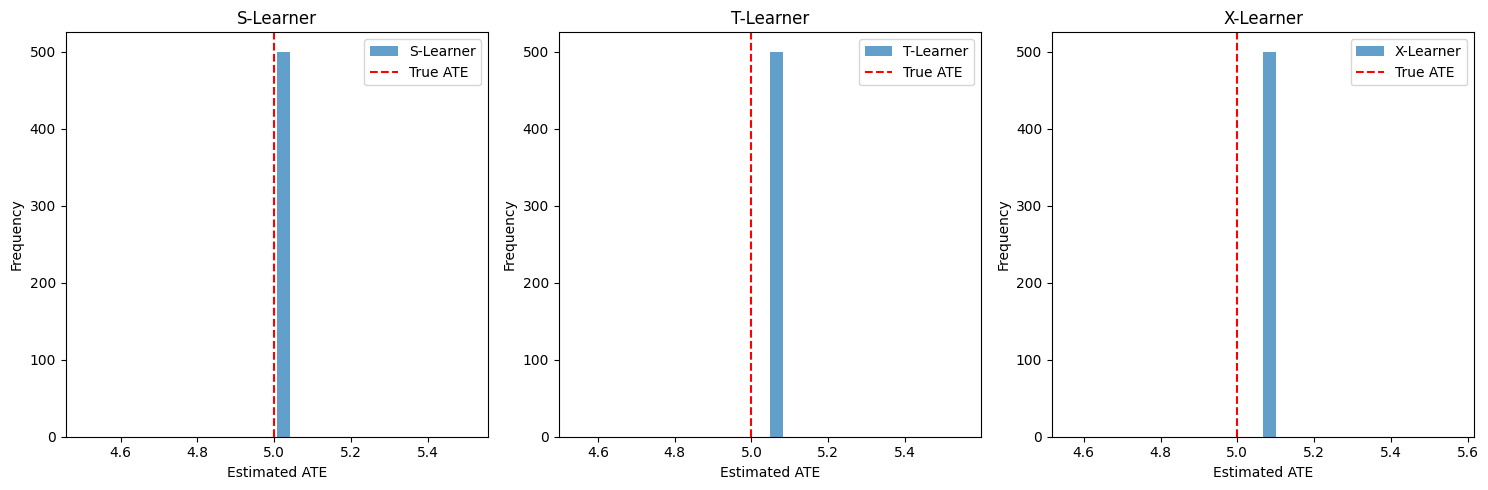

In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

# Simulate data
def simulate_data(n=30):
    np.random.seed(42)
    X = np.random.normal(0, 1, (n, 5))  # 5 covariates
    treatment = np.random.binomial(1, 0.5, n)
    treatment_effect = 5  # Constant treatment effect
    Y = 10 + 3 * X[:, 0] - 2 * X[:, 1] + treatment * treatment_effect + np.random.normal(0, 1, n)
    data = pd.DataFrame(X, columns=[f"X{i}" for i in range(1, 6)])
    data["treatment"] = treatment
    data["outcome"] = Y
    return data

# Meta-learners
def s_learner(train):
    model = lgb.LGBMRegressor(verbose=-1)
    train["combined_treatment"] = train["treatment"]
    model.fit(train.drop(columns=["outcome", "treatment"]), train["outcome"])
    treated = train.copy()
    treated["combined_treatment"] = 1
    control = train.copy()
    control["combined_treatment"] = 0
    y_treated = model.predict(treated.drop(columns=["outcome", "treatment"]))
    y_control = model.predict(control.drop(columns=["outcome", "treatment"]))
    return np.mean(y_treated - y_control)

def t_learner(train):
    treated = train[train["treatment"] == 1]
    control = train[train["treatment"] == 0]
    model_treated = lgb.LGBMRegressor(verbose=-1)
    model_control = lgb.LGBMRegressor(verbose=-1)
    model_treated.fit(treated.drop(columns=["outcome", "treatment"]), treated["outcome"])
    model_control.fit(control.drop(columns=["outcome", "treatment"]), control["outcome"])
    y_treated = model_treated.predict(train.drop(columns=["outcome", "treatment"]))
    y_control = model_control.predict(train.drop(columns=["outcome", "treatment"]))
    return np.mean(y_treated - y_control)

def x_learner(train):
    treated = train[train["treatment"] == 1]
    control = train[train["treatment"] == 0]
    model_treated = lgb.LGBMRegressor(verbose=-1)
    model_control = lgb.LGBMRegressor(verbose=-1)
    model_treated.fit(treated.drop(columns=["outcome", "treatment"]), treated["outcome"])
    model_control.fit(control.drop(columns=["outcome", "treatment"]), control["outcome"])
    imputed_control = treated["outcome"] - model_control.predict(treated.drop(columns=["outcome", "treatment"]))
    imputed_treated = model_treated.predict(control.drop(columns=["outcome", "treatment"])) - control["outcome"]
    model_tau_treated = lgb.LGBMRegressor(verbose=-1)
    model_tau_control = lgb.LGBMRegressor(verbose=-1)
    model_tau_treated.fit(treated.drop(columns=["outcome", "treatment"]), imputed_control)
    model_tau_control.fit(control.drop(columns=["outcome", "treatment"]), imputed_treated)
    tau_treated = model_tau_treated.predict(train.drop(columns=["outcome", "treatment"]))
    tau_control = model_tau_control.predict(train.drop(columns=["outcome", "treatment"]))
    propensity = len(treated) / len(train)
    return np.mean(propensity * tau_treated + (1 - propensity) * tau_control)

# Monte Carlo Simulation
n_simulations = 500
n_samples = 1000
s_learner_ates = []
t_learner_ates = []
x_learner_ates = []

for _ in range(n_simulations):
    data = simulate_data(n=n_samples)
    s_learner_ates.append(s_learner(data.copy()))
    t_learner_ates.append(t_learner(data.copy()))
    x_learner_ates.append(x_learner(data.copy()))

# Plot sampling distributions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(s_learner_ates, bins=30, alpha=0.7, label="S-Learner")
plt.axvline(5, color="red", linestyle="--", label="True ATE")
plt.title("S-Learner")
plt.xlabel("Estimated ATE")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(t_learner_ates, bins=30, alpha=0.7, label="T-Learner")
plt.axvline(5, color="red", linestyle="--", label="True ATE")
plt.title("T-Learner")
plt.xlabel("Estimated ATE")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(x_learner_ates, bins=30, alpha=0.7, label="X-Learner")
plt.axvline(5, color="red", linestyle="--", label="True ATE")
plt.title("X-Learner")
plt.xlabel("Estimated ATE")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

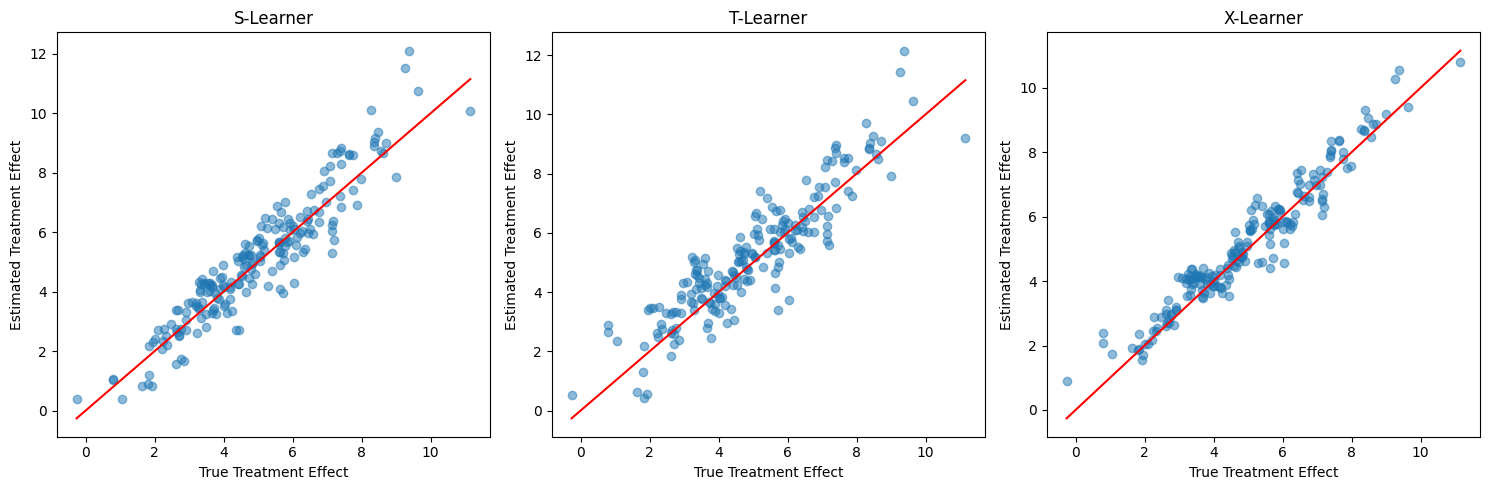

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Simulate data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, (n, 5))  # 5 covariates
treatment = np.random.binomial(1, 0.5, n)
treatment_effect = 5 + 2 * X[:, 0]  # True treatment effect depends on X[:, 0]
Y = 10 + 3 * X[:, 0] - 2 * X[:, 1] + treatment * treatment_effect + np.random.normal(0, 1, n)

data = pd.DataFrame(X, columns=[f"X{i}" for i in range(1, 6)])
data["treatment"] = treatment
data["outcome"] = Y

# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Meta-learners
def s_learner(train, test):
    model = RandomForestRegressor(random_state=42)
    train["combined_treatment"] = train["treatment"]
    model.fit(train.drop(columns=["outcome", "treatment"]), train["outcome"])
    test_with_treatment = test.copy()
    test_with_treatment["combined_treatment"] = 1
    test_without_treatment = test.copy()
    test_without_treatment["combined_treatment"] = 0
    y_treated = model.predict(test_with_treatment.drop(columns=["outcome", "treatment"]))
    y_control = model.predict(test_without_treatment.drop(columns=["outcome", "treatment"]))
    return y_treated - y_control

def t_learner(train, test):
    treated = train[train["treatment"] == 1]
    control = train[train["treatment"] == 0]
    model_treated = RandomForestRegressor(random_state=42)
    model_control = RandomForestRegressor(random_state=42)
    model_treated.fit(treated.drop(columns=["outcome", "treatment"]), treated["outcome"])
    model_control.fit(control.drop(columns=["outcome", "treatment"]), control["outcome"])
    y_treated = model_treated.predict(test.drop(columns=["outcome", "treatment"]))
    y_control = model_control.predict(test.drop(columns=["outcome", "treatment"]))
    return y_treated - y_control

def x_learner(train, test):
    treated = train[train["treatment"] == 1]
    control = train[train["treatment"] == 0]
    model_treated = RandomForestRegressor(random_state=42)
    model_control = RandomForestRegressor(random_state=42)
    model_treated.fit(treated.drop(columns=["outcome", "treatment"]), treated["outcome"])
    model_control.fit(control.drop(columns=["outcome", "treatment"]), control["outcome"])
    imputed_control = treated["outcome"] - model_control.predict(treated.drop(columns=["outcome", "treatment"]))
    imputed_treated = model_treated.predict(control.drop(columns=["outcome", "treatment"])) - control["outcome"]
    model_tau_treated = RandomForestRegressor(random_state=42)
    model_tau_control = RandomForestRegressor(random_state=42)
    model_tau_treated.fit(treated.drop(columns=["outcome", "treatment"]), imputed_control)
    model_tau_control.fit(control.drop(columns=["outcome", "treatment"]), imputed_treated)
    tau_treated = model_tau_treated.predict(test.drop(columns=["outcome", "treatment"]))
    tau_control = model_tau_control.predict(test.drop(columns=["outcome", "treatment"]))
    propensity = len(treated) / len(train)
    return propensity * tau_treated + (1 - propensity) * tau_control

# Estimate treatment effects
s_learner_te = s_learner(train_data.copy(), test_data.copy())
t_learner_te = t_learner(train_data.copy(), test_data.copy())
x_learner_te = x_learner(train_data.copy(), test_data.copy())

# True treatment effect
true_te = 5 + 2 * test_data["X1"].values

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(true_te, s_learner_te, alpha=0.5)
plt.plot([true_te.min(), true_te.max()], [true_te.min(), true_te.max()], color="red")
plt.title("S-Learner")
plt.xlabel("True Treatment Effect")
plt.ylabel("Estimated Treatment Effect")

plt.subplot(1, 3, 2)
plt.scatter(true_te, t_learner_te, alpha=0.5)
plt.plot([true_te.min(), true_te.max()], [true_te.min(), true_te.max()], color="red")
plt.title("T-Learner")
plt.xlabel("True Treatment Effect")
plt.ylabel("Estimated Treatment Effect")

plt.subplot(1, 3, 3)
plt.scatter(true_te, x_learner_te, alpha=0.5)
plt.plot([true_te.min(), true_te.max()], [true_te.min(), true_te.max()], color="red")
plt.title("X-Learner")
plt.xlabel("True Treatment Effect")
plt.ylabel("Estimated Treatment Effect")

plt.tight_layout()
plt.show()
